In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

from imcascade import Fitter, ImcascadeResults
from imcascade.psf_fitter import PSFFitter
from imcascade.utils import expand_mask

import sep
from astropy.io import fits
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy.nddata import Cutout2D

In [2]:
#Load data, downloaded from HSC archive, this a massive galaxy at z~0.1 at the sky location below

img_fits = fits.open('data/cutout-HSC-I-9613-pdr2_wide-210107-180153.fits')
psf_fits = fits.open('data/psf-calexp-pdr2_wide-HSC-I-9613-5,4-213.22000-0.79776.fits')

ra,dec = 2.1322e+02*u.deg, 7.9776e-01*u.deg
examp_coord = SkyCoord(ra = ra, dec = dec)

#### First we fit the PSF with a series of gaussian
There is some incentive to use a small number of gaussians to define the PSF as it decreasese the time to render a model image. The following function first fits the PSF profile in 1D to decide what the best widths are. Then a 2D fit is used to find the correct weights

[1.45167362 3.04077773 7.03558772] [0.67461312 0.25802406 0.06529097]


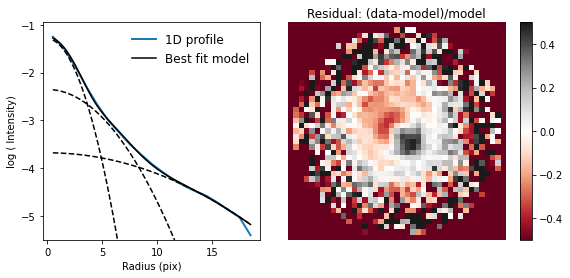

In [3]:
psf_fitter = PSFFitter(psf_fits[0].data,oversamp = 1)
psf_sig,psf_a,chi2, fig = psf_fitter.fit_N(3, plot = True)
#We set 'plot = True' to assess fit. Seems to be a pretty good
print (psf_sig,psf_a)
plt.show()

#### Now we move on to fit the galaxy

In [4]:
#Retrieve science and variance images from FITS
raw_img = img_fits[1].data.byteswap().newbyteorder()
raw_var = img_fits[3].data.byteswap().newbyteorder()

#We will us a 200x200 cutout to fit the galaxy
cutout_img = Cutout2D(raw_img, examp_coord, 200*u.pixel, wcs = WCS(img_fits[1].header))
cutout_var= Cutout2D(raw_var, examp_coord, 200*u.pixel, wcs = WCS(img_fits[1].header))
img = np.array(cutout_img.data.data)
var = np.array(cutout_var.data.data)

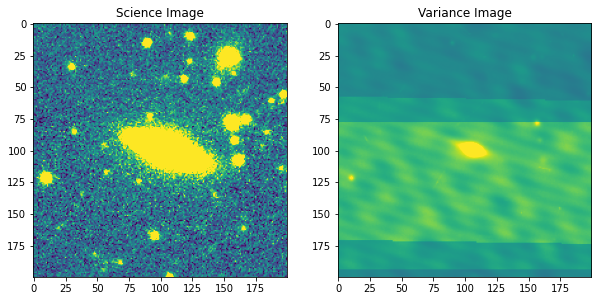

In [5]:
#Let's take a look at the data quickly, everything looks pretty good!
fig, (ax1,ax2) = plt.subplots(1,2, figsize = (10,5))
ax1.imshow(img, vmin = -0.1, vmax = 0.2)
ax1.set_title('Science Image')
ax2.imshow(var,vmin = 0, vmax = 0.005)
ax2.set_title('Variance Image')
plt.show()

<ipython-input-6-3809ce24e65d>:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. Use `int` by itself, which is identical in behavior, to silence this warning. If you specifically wanted the numpy scalar type, use `np.int_` here.
  obj,seg = sep.extract(img - bkg.back(), 2.5, err = np.sqrt(var), deblend_cont = 0.005,segmentation_map = True)


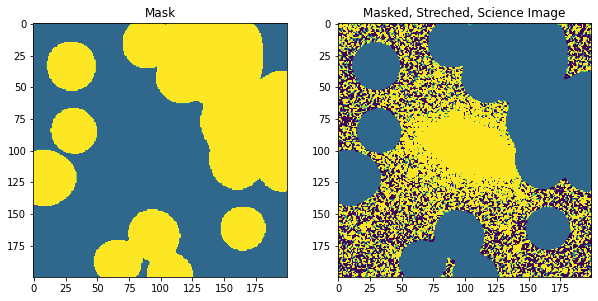

In [6]:
#Now we use sep to detct objects and build a mask!
bkg = sep.Background(img)
x_cent,y_cent = int(img.shape[0]/2.) , int(img.shape[1]/2.)
obj,seg = sep.extract(img - bkg.back(), 2.5, err = np.sqrt(var), deblend_cont = 0.005,segmentation_map = True)
seg[np.where(seg == seg[x_cent,y_cent])] = 0
mask_raw = seg > 0

#Convolve mask with a gaussian to expand it and make sure that all low-SB emission is masked
mask = expand_mask(mask_raw)
mask = np.array(mask, dtype = bool)


fig, (ax1,ax2) = plt.subplots(1,2, figsize = (10,5))
ax1.imshow(mask, vmin = -0.1, vmax = 0.2)
ax1.set_title('Mask')
ax2.imshow(img*np.logical_not(mask),vmin = -0.01, vmax = 0.02)
ax2.set_title('Masked, Streched, Science Image')
plt.show()

In [7]:
#Here we decide what widths of gaussians we use to fit the galaxy with. In general they should range from ~1 pixel to 1/3 of the cutout size with 8-10 gaussians
#being the sweet spot for this size cutout. Also it is often best to use a log scale like here to focus more on the center where there is more signal.
#See XXXX for more details

sig = np.logspace(np.log10(0.75),np.log10(60), num = 9)

#We can also specify inital conditions to help make inital guesses. Here we specify the estimated half light radii and total flux. The code make some intelligent guesses on the inital conditions and the bounds
#It is also possible to specify guessea and bounds for individual components, sky values etc. but this is more involved. See details at  XXYZ
init_dict  = {'re':7., 'flux': 5000.}

In [9]:
#The fitter instance containing all the information is initialized below
fitter = Fitter(img,sig, psf_sig, psf_a, weight = 1./var, mask = mask, init_dict = init_dict, log_file = 'examp.log')

# Now we fit the galaxy using the least squares minimization routine. This takes ~2 min on my laptop
start = time.time()
min_res = fitter.run_ls_min()
end = time.time()
#print ('%.2f min'%( (end-start)/60.))

2021-03-31 11:04:45,156 - Running least squares minimization
2021-03-31 11:10:32,440 - Finished least squares minimization


In [16]:
fitter.log_like(fitter.min_res.x)

-260.4125051927076

In [19]:
fitter.param_init[4:-3]

array([1.3645624 , 2.05558264, 2.6394756 , 3.04999055, 3.22087679,
       3.0858836 , 2.57876027, 1.63325608, 0.18312032])

In [21]:
import dynesty

In [ ]:
##Try normal nested sampler and bootsraping for dyanmic

In [22]:
dynesty.DynamicNestedSampler?

Signature:
dynesty.DynamicNestedSampler(
    loglikelihood,
    prior_transform,
    ndim,
    bound='multi',
    sample='auto',
    periodic=None,
    reflective=None,
    update_interval=None,
    first_update=None,
    npdim=None,
    rstate=None,
    queue_size=None,
    pool=None,
    use_pool=None,
    logl_args=None,
    logl_kwargs=None,
    ptform_args=None,
    ptform_kwargs=None,
    gradient=None,
    grad_args=None,
    grad_kwargs=None,
    compute_jac=False,
    enlarge=None,
    bootstrap=0,
    vol_dec=0.5,
    vol_check=2.0,
    walks=25,
    facc=0.5,
    slices=5,
    fmove=0.9,
    max_move=100,
    **kwargs,
)
Docstring:
Initializes and returns a sampler object for Dynamic Nested Sampling.

Parameters
----------
loglikelihood : function
    Function returning ln(likelihood) given parameters as a 1-d `~numpy`
    array of length `ndim`.

prior_transform : function
    Function translating a unit cube to the parameter space according to
    the prior. The input is a

In [20]:
fitter.min_res.x[4:-3]

array([ 2.8397207 , -1.30103   ,  2.86128292,  2.9703491 , -1.30103   ,
        3.3012015 ,  2.94315361, -1.30103   ,  2.60121491])

In [9]:
#Here we initialize in instance of the 'results' class that will allows us to easier perform the morphological analysis.
ls_res = ImcascadeResults(fitter)

#This function calculates a set of common morphological quantities. 
#We have only run the least-squares minimization and no bayesian method so there are no error bars attributed to the measurements yet
ls_res.run_basic_analysis()

Could not load - posterier
Could not load - post_method


{'flux': 5386.598547754913,
 'r20': 2.263844794321935,
 'r50': 7.8156223774382605,
 'r80': 20.343004394484176,
 'r90': 29.301356288885305,
 'C80_20': 8.986041996124252,
 'C90_50': 3.74907523340316}

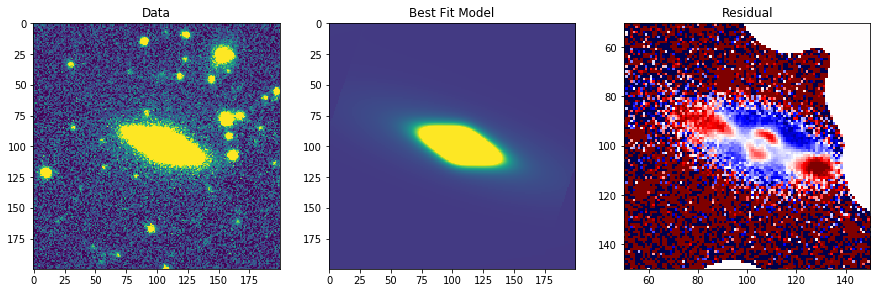

In [10]:
## Let's take a quick look at the best fit-model to make sure it looks god
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize = (15,5))

best_fit_mod = fitter.make_model(min_res.x) #generate a model image using the best fitting parameters

#Calculate the residual image and mask out the other sources
resid = (fitter.img - best_fit_mod) / best_fit_mod
resid *= np.logical_not(fitter.mask)

ax1.set_title('Data')
ax1.imshow(fitter.img,vmin = -0.05, vmax = 0.3)
ax2.set_title('Best Fit Model')
ax2.imshow(best_fit_mod, vmin = -0.05, vmax = 0.3)
ax3.set_title('Residual')
ax3.imshow(resid, vmin = -0.5, vmax = 0.5, cmap = 'seismic')
ax3.set_xlim([50,150])
ax3.set_ylim([150,50])

plt.show()

While there are some discrepencies the overall fit is pretty good. This is a complex, well resolved galaxy that is not perfectly fit with a fixed PA or axis ratio so some residuals are expected.

In [11]:
##### If you were to run in bayesian mode and save the posterier, this is what it would look like.

#Here we use the 'express' method which pre-renders the images based on the best fit x0,y0,q and PA, and only varies the weight of each Gaussian component
#This method is much faster than a full bayesian approach where everything is varied at the cost of less freedom as the 'structural' parameters are fixed

# start = time.time()
# dyn_exp_post = fitter.run_dynesty(method = 'express', sampler_kwargs = {'bounds':'cubes','update_interval':75.,'scale':1})
# end = time.time()
# _ = fitter.save_results('examp_dyn_exp.asdf', run_basic_analysis = False)
# print ('%.2f min'%( (end-start)/60.))

# This takes ~1 hour to run on my laptop

In [12]:
#Instead we can just load the results from the saved file. As is shown here the ImcascadeResults class can also load a saved asdf file as an input
dyn_res = ImcascadeResults('examp_dyn_exp.asdf')

dyn_res.run_basic_analysis(zpt = 27, errp_lo = 5, errp_hi = 95,cutoff = 75.) #Specifying the zpt also lets us calcualte the magnitude, we can also specify the percentiles used to calculate the error bars, here we use +/- 2 sigma

{'flux': array([5253.11649039,    8.1645204 ,    8.33757333]),
 'mag': array([1.76989574e+01, 1.72187862e-03, 1.68879013e-03]),
 'r20': array([2.19465297, 0.00794949, 0.00747571]),
 'r50': array([7.46587504, 0.02160441, 0.02196691]),
 'r80': array([19.20355628,  0.06374163,  0.06474222]),
 'r90': array([26.44786402,  0.13576791,  0.13942262]),
 'C80_20': array([8.75029442, 0.02944761, 0.03017614]),
 'C90_50': array([3.54248442, 0.01038278, 0.01071943])}

In [13]:
rplot = np.linspace(0, 50, num = 200)

#Here we show the posterier distribution of the surface_brightness profile
sbp_all = dyn_res.calc_sbp(rplot)

# Using return_ind we find the contributions of each individual gaussian component
sbp_ind = ls_res.calc_sbp(rplot,return_ind = True)

#Here we calculate the curve-of-growth for the posterier
cog_all = dyn_res.calc_cog(rplot)

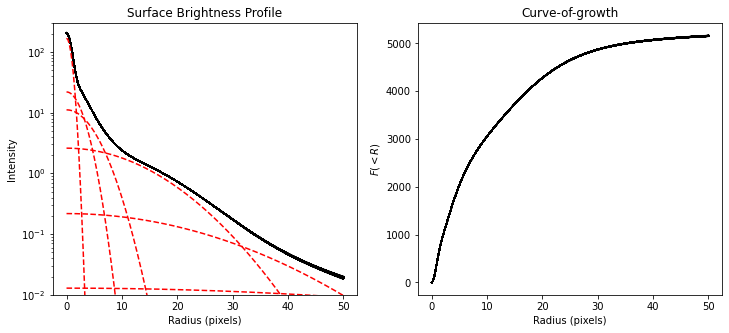

In [14]:
#Here we plot both!
fig, (ax1,ax2) = plt.subplots(1,2, figsize = (12,5))
ax1.plot(rplot, sbp_all[:,::20], 'k-', alpha = 0.05)
ax1.plot(rplot, sbp_ind, 'r--', alpha = 1.)

ax1.set_yscale('log')
ax1.set_ylim([1e-2,3e2])
ax1.set_title('Surface Brightness Profile')
ax1.set_xlabel('Radius (pixels)')
ax1.set_ylabel('Intensity')


ax2.plot(rplot,cog_all[:,::20], 'k-', alpha = 0.05)
#ax2.set_yscale('log')
ax2.set_title('Curve-of-growth')
ax2.set_xlabel('Radius (pixels)')
ax2.set_ylabel(r'$F(<R)$')
plt.show()